In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import h5py
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential

import pydot
from IPython.display import SVG


import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File('train_happy.h5')
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('test_happy.h5')
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset("train_happy.h5","test_happy.h5")

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


C:\Users\gbouaziz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
C:\Users\gbouaziz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


Image shape : (64, 64, 3)


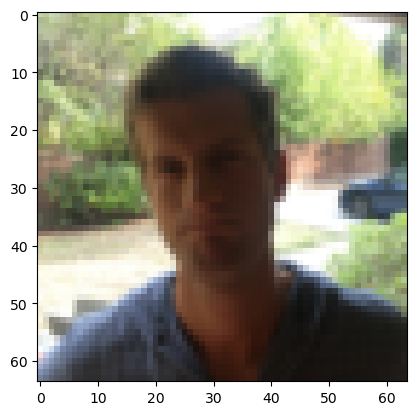

In [4]:
# Sample image from dataset
print("Image shape :",X_train_orig[10].shape)
imshow(X_train_orig[10])

Building Model

In [5]:
model = Sequential()
model.add(layers.Input(shape=(64, 64, 3)))
model.add(layers.Conv2D(32, 2, strides=2, activation="relu"))
model.add(layers.BatchNormalization(axis=1))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        416       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 8,737
Trainable params: 8,673
Non-trainabl

In [6]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=["accuracy"])

In [7]:
history_model = model.fit(X_train, Y_train, epochs=5, batch_size=1)

Epoch 1/5
600/600 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.7650
Epoch 2/5
600/600 [==============================] - 1s 2ms/step - loss: 0.1248 - accuracy: 0.9517
Epoch 3/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0950 - accuracy: 0.9667
Epoch 4/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0832 - accuracy: 0.9733
Epoch 5/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0678 - accuracy: 0.9750


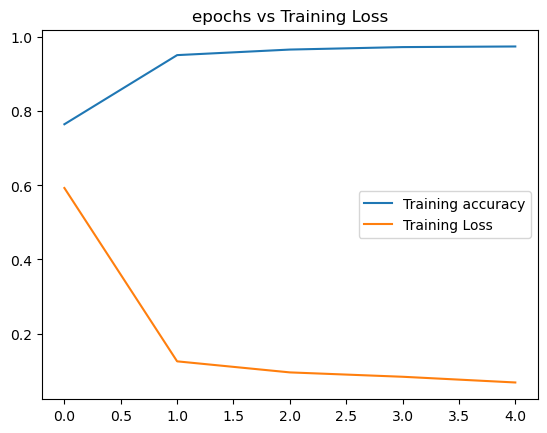

In [8]:
train_accuracy = history_model.history['accuracy']
train_loss = history_model.history['loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Training accuracy')
plt.plot(count, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

Evaluate Test set

In [9]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 4ms/step - loss: 0.1886 - accuracy: 0.9333
Test accuracy: 0.9333333373069763


Confusion Matrix


5/5 [==============================] - 0s 3ms/step
[[0.44 0.  ]
 [0.56 0.  ]]


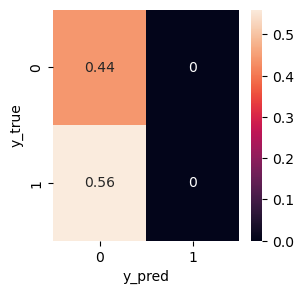

In [10]:
from sklearn.metrics import confusion_matrix
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(Y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(Y_test, y_prediction , normalize='pred')
print(result)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(result, annot=True)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()